# **Импортирую нужные библиотеки, модели и функции:**


In [ ]:
!pip install mpld3
import numpy as np
import pandas as pd
from openpyxl import load_workbook
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import mpld3

     |████████████████████████████████| 201 kB 4.4 MB/s 


# **Открываю таблицу с опросом студентов и создаю список имен колонок в таблице:**

In [ ]:


wb = load_workbook('studentsData.xlsx')

sheet = wb.get_sheet_by_name('Report')

col_names = []

for i in range(1, sheet.max_column + 1):
    col_names.append(sheet.cell(row = 1, column = i).value)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  """


# **Открываю ту же таблицу, только в формате .csv и создаю pandas.DataFrame из этой таблицы, удаляю из таблицы студентов, у которых не написана группа и меняю названия групп на более удобные для дальнейшей работы, например "Н НН БИиПМ 16 ПМИ" превращается в "16pmi".**

In [ ]:
data = pd.read_csv("studentsData.csv", skiprows=1, header=None, names=col_names)
pd.set_option("display.max_rows", None, "display.max_columns", None)
for i in range(len(data)):
#     data.at[i, 'Номер курса'] = data.at[i, 'Номер курса'][0]
    if data.loc[i]['Группа пользователей'] == ' ' or data.at[i, 'Группа пользователей'].find('МАГ') != -1:
        data = data.drop([i])
        
s = pd.Series([i for i in range(len(data))])
data = data.set_index(s)

years = [str(i) for i in range(15, 19)]
directions = {'БИ' : 'bi', 'ПИ' : 'pi', 'ПМИ' : 'pmi', 'ФМ' : 'fm'}
for i in range(len(data)):
    name = ''
    for year in years:
        if data.at[i, 'Группа пользователей'].find(year) != -1:
            name = year
            break
    for direction in directions:
        if data.at[i, 'Группа пользователей'][-7:].find(direction) != -1:
            if name != '':
                name += directions[direction]
            break
    data.at[i, 'Группа пользователей'] = name
    if len(data.at[i, 'Группа пользователей']) < 3:
        data = data.drop([i])
                    
            
# s = pd.Series([i for i in range(len(data))])
# data = data.set_index(s)

data = data.drop(columns = 'Номер курса')
data = data.sort_values(by='Группа пользователей', ascending=False)

s = pd.Series([i for i in range(len(data))])
data = data.set_index(s)


# **В зависимости от года в группе студента, открываю таблицу нужного года и ищу в ней этого студента, смотрю есть ли у него неудовлетворительные оценки, и затем добавляю колонку с этой информацией в нашу основную таблицу data:**

In [ ]:
fails = {}
found_flag = False
wb = load_workbook(data.loc[1]['Группа пользователей'][:2]+'bi.xlsx')
sheet = wb.get_sheet_by_name('Отчет')
prev_num = data.loc[1]['Группа пользователей'][:2]
for i in range(len(data)):
    cur_name = data.loc[i]['Учащийся']
    if data.loc[i]['Группа пользователей'][:2] != prev_num:
        wb = load_workbook(data.loc[i]['Группа пользователей'][:2]+'bi.xlsx')
        sheet = wb.get_sheet_by_name('Отчет')
        prev_num = data.loc[i]['Группа пользователей'][:2]
    for i in range(12, sheet.max_row + 1):
        c = sheet.cell(row = i, column = 3)
        if(c.value == cur_name):
            found_flag = True
            fail = sheet.cell(row = i, column = 17).value
            if fail == 'Да':
                fails[cur_name] = 'Да'
            else:
                fails[cur_name] = 'Нет'
            break
            
data['Наличие неудовлетворительных оценок'] = ['' for i in range(len(data))]
for i in range(len(data)):
  if data.loc[i]['Учащийся'] in fails:
    data.at[i, 'Наличие неудовлетворительных оценок'] = fails[data.loc[i]['Учащийся']]
  else:
    data.at[i, 'Наличие неудовлетворительных оценок'] = ''
# print(len(data))
# print(len(fails))
  if data.loc[i]['Наличие неудовлетворительных оценок'] == '':
        data = data.drop([i])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  # Remove the CWD from sys.path while we load stuff.


# **Удаляю некоторые бесполезные колонки:**

In [ ]:
data = data.drop(['Учащийся', 'Факультет', 'Группа пользователей', 'Дата прохождения теста', 'Балл теста', 'Средний балл'], axis = 1)

# **Устанавливаю индексы по порядку:**

In [ ]:
s = pd.Series([i for i in range(len(data))])
data = data.set_index(s)

data.head()


,Укажите Ваше семейное положение.,Работаете ли Вы?,Образование Ваших родителей?,Увлекаетесь ли Вы спортом?,На какие средства Вы живете?,Каковы условия Вашего проживания?,"Оцените, как Вам нравится учиться?",Получали ли Вы стипендию? (в течение последнего года),Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,Как много Вы пропускаете аудиторных занятий?,Какая у Вас семья?,Бывают ли у Вас долги по экзаменам/зачетам?,Брали ли Вы академический отпуск?,Ходили ли Вы на подготовительные курсы перед поступлением в вуз?,С какими оценками Вы закончили школу?,"Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",Участвуете ли Вы в олимпиадах?,Наличие неудовлетворительных оценок
0,Холост/не замужем,Нет,Высшее (вуз);Среднее (школа),"да, хожу на фитнес или в тренажерный зал",Деньги дают родные,Живете с родителями/родными/супругом,3,Нет,Все свободное время,Не пропускаете,Оба родителя вместе,Нет,Нет,Нет,4-5,"да, по основным предметам моей специальности;д...",Нет,Нет
1,Холост/не замужем,Нет,Высшее (вуз),"да, хожу на фитнес или в тренажерный зал;да, з...",Получаете стипендию;Деньги дают родные,Живете с родителями/родными/супругом,5,Да,От 1 до 3 часов в день,Не пропускаете,Оба родителя вместе,Нет,Нет,Нет,Медаль,нет,Да,Нет
2,Холост/не замужем,Нет,Высшее (вуз),"да, хожу на фитнес или в тренажерный зал",Деньги дают родные,Живете с родителями/родными/супругом,5,Да,Более 3 часов в день,Не пропускаете,Оба родителя вместе,Нет,Нет,Нет,Медаль,нет,Нет,Нет
3,Холост/не замужем,Да,Высшее (вуз),"да, хожу на фитнес или в тренажерный зал",Работаете;Деньги дают родные,Живете с родителями/родными/супругом,2,Нет,Более 3 часов в день,Среднее количество пропусков,Оба родителя вместе,1-2 раза в год,Нет,Нет,4-5,нет,Нет,Да
4,Холост/не замужем,Нет,Высшее (вуз),"да, хожу на фитнес или в тренажерный зал",Деньги дают родные,Живете с родителями/родными/супругом,4,Да,Более 3 часов в день,Не пропускаете,Оба родителя вместе,Нет,Нет,Нет,Медаль,нет,"Нет, но собираюсь в этом году",Нет


In [ ]:
col_exceptions = []
col_exceptions.append('Оцените, как Вам нравится учиться?')
for i, item in enumerate(data['Оцените, как Вам нравится учиться?']):
  data['Оцените, как Вам нравится учиться?'][i] = int(item)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# **Немного оптимизирую ответы на вопросы с большим количеством ответов:**

In [ ]:
data['Увлекаетесь ли Вы спортом?'].value_counts()

In [ ]:
data['Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?'].value_counts()

In [ ]:
for i, item in enumerate(data['Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?']):
  if item.startswith('От 1 до 3 часов в день;'):
    data['Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?'][i] = 'От 1 до 3 часов в день'

In [ ]:
for i, item in enumerate(data['Каковы условия Вашего проживания?']):
  if item == 'Живете в общежитии;Живете в собственной/съемной квартире один;Живете с родителями/родными/супругом;Живете с друзьями в собственной/съемной квартире':
    data['Каковы условия Вашего проживания?'][i] = 'Живете в общежитии'
  elif item == 'Живете в собственной/съемной квартире один;Живете с друзьями в собственной/съемной квартире' or item == 'Живете в собственной/съемной квартире один;Живете с родителями/родными/супругом':
    data['Каковы условия Вашего проживания?'][i] = 'Живете в собственной/съемной квартире один'
  elif item == 'Живете с родителями/родными/супругом;Живете с друзьями в собственной/съемной квартире':
    data['Каковы условия Вашего проживания?'][i] = 'Живете с родителями/родными/супругом'

In [ ]:
data['Каковы условия Вашего проживания?'].value_counts()

In [ ]:
# data['Увлекаетесь ли Вы спортом?'].value_counts()
for i, item in enumerate(data['Увлекаетесь ли Вы спортом?']):
  if item == 'да, занимаюсь шахматами/шашками':
    data['Увлекаетесь ли Вы спортом?'][i] = 'Шахматы'
  elif item.startswith('да') and 'шахматами' in item:
    data['Увлекаетесь ли Вы спортом?'][i] = 'Спорт, шахматы'
  elif item.startswith('нет'):
    data['Увлекаетесь ли Вы спортом?'][i] = 'Нет'
  elif item != 'Другой ответ':
    data['Увлекаетесь ли Вы спортом?'][i] = 'Спорт'

In [ ]:
data['Образование Ваших родителей?'].value_counts()

In [ ]:
data['На какие средства Вы живете?'].value_counts()

In [ ]:
data['Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?'].value_counts()

In [ ]:
data['Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?'].value_counts()

# **Значения в колонки с вопросами, на которые есть лишь 2 ответа, меняю на 0 и 1, а к колонкам, где больше 2 ответов, применяю one-hot encoding (функция get_dummies):**

In [ ]:
for col_name in data:
  if col_name not in col_exceptions:
    if len(set(data[col_name].values)) == 2:
      data[col_name] = data[col_name].astype('category')
      data[col_name] = data[col_name].cat.codes
    else:
      data = pd.get_dummies(data, columns = [col_name])

data.head()

,Работаете ли Вы?,"Оцените, как Вам нравится учиться?",Получали ли Вы стипендию? (в течение последнего года),Брали ли Вы академический отпуск?,Ходили ли Вы на подготовительные курсы перед поступлением в вуз?,Наличие неудовлетворительных оценок,Укажите Ваше семейное положение._Живу с мч/девушкой,Укажите Ваше семейное положение._Замужем/женат,Укажите Ваше семейное положение._Холост/не замужем,Образование Ваших родителей?_Без образования,Образование Ваших родителей?_Высшее (вуз),Образование Ваших родителей?_Высшее (вуз);Незаконченное высшее,Образование Ваших родителей?_Высшее (вуз);Среднее (школа),"Образование Ваших родителей?_Высшее (вуз);Среднее (школа);Среднее специальное (училище, техникум и пр.)","Образование Ваших родителей?_Высшее (вуз);Среднее специальное (училище, техникум и пр.)",Образование Ваших родителей?_Незаконченное высшее,"Образование Ваших родителей?_Незаконченное высшее;Среднее специальное (училище, техникум и пр.)",Образование Ваших родителей?_Среднее (школа),"Образование Ваших родителей?_Среднее (школа);Среднее специальное (училище, техникум и пр.)","Образование Ваших родителей?_Среднее специальное (училище, техникум и пр.)",Увлекаетесь ли Вы спортом?_Другой ответ,Увлекаетесь ли Вы спортом?_Нет,Увлекаетесь ли Вы спортом?_Спорт,"Увлекаетесь ли Вы спортом?_Спорт, шахматы",Увлекаетесь ли Вы спортом?_Шахматы,На какие средства Вы живете?_Деньги дают родные,На какие средства Вы живете?_Получаете стипендию,На какие средства Вы живете?_Получаете стипендию;Деньги дают родные,На какие средства Вы живете?_Работаете,На какие средства Вы живете?_Работаете;Деньги дают родные,На какие средства Вы живете?_Работаете;Получаете стипендию;Деньги дают родные,Каковы условия Вашего проживания?_Живете в общежитии,Каковы условия Вашего проживания?_Живете в собственной/съемной квартире один,Каковы условия Вашего проживания?_Живете с друзьями в собственной/съемной квартире,Каковы условия Вашего проживания?_Живете с родителями/родными/супругом,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_7 часов в неделю,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_Более 3 часов в день,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_Все свободное время,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_Все свободное время;Более 3 часов в день,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_Готовлюсь только перед занятиями,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_От 1 до 3 часов в день,Как много Вы пропускаете аудиторных занятий?_Не пропускаете,Как много Вы пропускаете аудиторных занятий?_Регулярно пропускаете,Как много Вы пропускаете аудиторных занятий?_Среднее количество пропусков,Какая у Вас семья?_В разводе,Какая у Вас семья?_Оба родителя вместе,Какая у Вас семья?_Один родитель,Какая у Вас семья?_Я - сирота,Бывают ли у Вас долги по экзаменам/зачетам?_1-2 раза в год,Бывают ли у Вас долги по экзаменам/зачетам?_1-2 раза в семестр,Бывают ли у Вас долги по экзаменам/зачетам?_Всегда,Бывают ли у Вас долги по экзаменам/зачетам?_Нет,С какими оценками Вы закончили школу?_3-4,С какими оценками Вы закончили школу?_4-5,С какими оценками Вы закончили школу?_Медаль,"Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_да, по иностранным языкам","Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_да, по общеобразовательным предметам","Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_да, по основным предметам моей специальности","Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_да, по основным предметам моей специальности;да, по иностранным языкам","Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_да, по основным предметам моей специальности;да, по общеобразовательным предметам;да, по иностранным языкам","Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_нет",Участвуете ли Вы

In [ ]:
beginnings = ['Образование Ваших родителей?_', 'Каковы условия Вашего проживания?_', 'На какие средства Вы живете?_', 
              'Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_', 'Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_']

for beginning in beginnings:
  for col_name in data:
    if col_name.startswith(beginning) and ';' in col_name:
      variations = col_name[len(beginning):].split(';')
      for i, answer in enumerate(data[col_name]):
        if answer == 1:
          for var in variations:
            data[f'{beginning}{var}'][i] = 1
      data = data.drop(col_name, axis=1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Работаете ли Вы?,"Оцените, как Вам нравится учиться?",Получали ли Вы стипендию? (в течение последнего года),Брали ли Вы академический отпуск?,Ходили ли Вы на подготовительные курсы перед поступлением в вуз?,Наличие неудовлетворительных оценок,Укажите Ваше семейное положение._Живу с мч/девушкой,Укажите Ваше семейное положение._Замужем/женат,Укажите Ваше семейное положение._Холост/не замужем,Образование Ваших родителей?_Без образования,Образование Ваших родителей?_Высшее (вуз),Образование Ваших родителей?_Незаконченное высшее,Образование Ваших родителей?_Среднее (школа),"Образование Ваших родителей?_Среднее специальное (училище, техникум и пр.)",Увлекаетесь ли Вы спортом?_Другой ответ,Увлекаетесь ли Вы спортом?_Нет,Увлекаетесь ли Вы спортом?_Спорт,"Увлекаетесь ли Вы спортом?_Спорт, шахматы",Увлекаетесь ли Вы спортом?_Шахматы,На какие средства Вы живете?_Деньги дают родные,На какие средства Вы живете?_Получаете стипендию,На какие средства Вы живете?_Работаете,Каковы условия Вашего проживания?_Живете в общежитии,Каковы условия Вашего проживания?_Живете в собственной/съемной квартире один,Каковы условия Вашего проживания?_Живете с друзьями в собственной/съемной квартире,Каковы условия Вашего проживания?_Живете с родителями/родными/супругом,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_7 часов в неделю,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_Более 3 часов в день,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_Все свободное время,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_Готовлюсь только перед занятиями,Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_От 1 до 3 часов в день,Как много Вы пропускаете аудиторных занятий?_Не пропускаете,Как много Вы пропускаете аудиторных занятий?_Регулярно пропускаете,Как много Вы пропускаете аудиторных занятий?_Среднее количество пропусков,Какая у Вас семья?_В разводе,Какая у Вас семья?_Оба родителя вместе,Какая у Вас семья?_Один родитель,Какая у Вас семья?_Я - сирота,Бывают ли у Вас долги по экзаменам/зачетам?_1-2 раза в год,Бывают ли у Вас долги по экзаменам/зачетам?_1-2 раза в семестр,Бывают ли у Вас долги по экзаменам/зачетам?_Всегда,Бывают ли у Вас долги по экзаменам/зачетам?_Нет,С какими оценками Вы закончили школу?_3-4,С какими оценками Вы закончили школу?_4-5,С какими оценками Вы закончили школу?_Медаль,"Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_да, по иностранным языкам","Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_да, по общеобразовательным предметам","Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_да, по основным предметам моей специальности","Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?_нет",Участвуете ли Вы в олимпиадах?_Да,Участвуете ли Вы в олимпиадах?_Нет,"Участвуете ли Вы в олимпиадах?_Нет, но собираюсь в этом году"
0,1,3,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0
1,1,5,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0
2,1,5,0,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0
3,0,2,1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,1,4,0,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1


# **Подготавливаю данные к обучению модели на них:**

In [ ]:
X = data.drop('Наличие неудовлетворительных оценок', axis = 1).values
y = data['Наличие неудовлетворительных оценок'].values

print(np.shape(X))
print(np.shape(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 0)


(240, 51)
(240,)


# **Создаю и обучаю модель Случайного Леса, вывожу результаты важных метрик:**

In [ ]:
randomForest = RandomForestClassifier(criterion='gini', max_depth = 8)
randomForest.fit(X_train, y_train)
while randomForest.score(X_test, y_test) < 0.8:
  randomForest.fit(X_train, y_train)
  
y_pred = randomForest.predict(X_test)
precision_first_class = precision_score(y_test, y_pred, pos_label=1)
precision_zero_class = precision_score(y_test, y_pred, pos_label=0)

recall_first_class = recall_score(y_test, y_pred, pos_label=1)
recall_zero_class = recall_score(y_test, y_pred, pos_label=0)

accuracy = accuracy_score(y_test, y_pred)

print(f'Precision of class 1 is {precision_first_class}')
print(f'Precision of class 0 is {precision_zero_class}')
print(f'Recall of class 1 is {recall_first_class}')
print(f'Recall of class 0 is {recall_zero_class}')
print(f'Accuracy score is {accuracy}')

Precision of class 1 is 0.7419354838709677
Precision of class 0 is 0.9411764705882353
Recall of class 1 is 0.9583333333333334
Recall of class 0 is 0.6666666666666666
Accuracy score is 0.8125


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


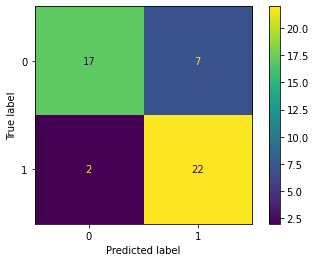

In [ ]:
plot_confusion_matrix(randomForest, X_test, y_test) 

# **Создаю и обучаю Решающее Дерево, вывожу результаты важных метрик:**

In [ ]:
decisionTree = DecisionTreeClassifier(criterion='gini', max_depth = 8)
decisionTree.fit(X_train, y_train)

y_pred = decisionTree.predict(X_test)
precision_first_class = precision_score(y_test, y_pred, pos_label=1)
precision_zero_class = precision_score(y_test, y_pred, pos_label=0)

recall_first_class = recall_score(y_test, y_pred, pos_label=1)
recall_zero_class = recall_score(y_test, y_pred, pos_label=0)

accuracy = accuracy_score(y_test, y_pred)

print(f'Precision of class 1 is {precision_first_class}')
print(f'Precision of class 0 is {precision_zero_class}')
print(f'Recall of class 1 is {recall_first_class}')
print(f'Recall of class 0 is {recall_zero_class}')
print(f'Accuracy score is {accuracy}')

Precision of class 1 is 0.8
Precision of class 0 is 0.8260869565217391
Recall of class 1 is 0.8333333333333334
Recall of class 0 is 0.7916666666666666
Accuracy score is 0.8125


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


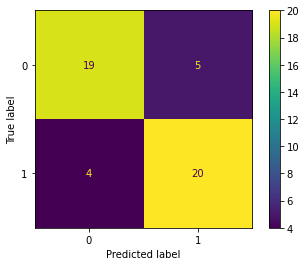

In [ ]:
plot_confusion_matrix(decisionTree, X_test, y_test) 

# **Строю решающее дерево глубины 2, чтобы на картинке было видно какие признаки дерево выбирает для наилучшего разделения данных:**

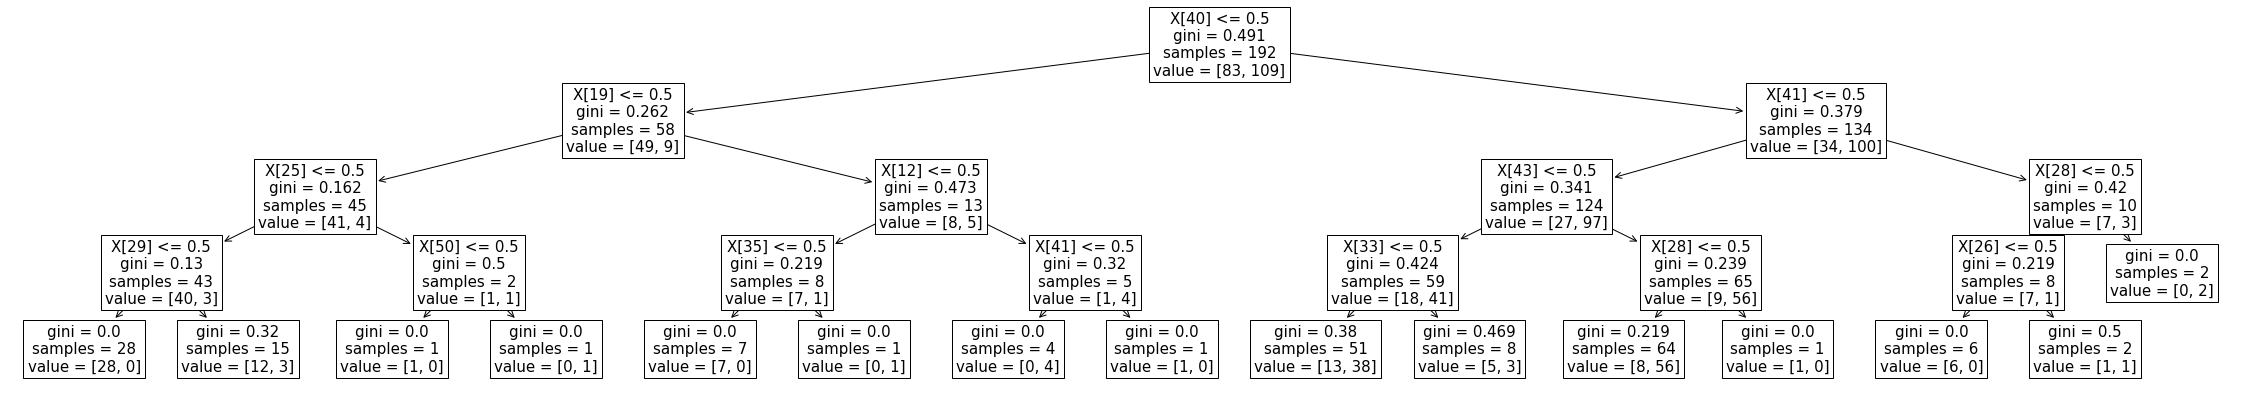

In [ ]:
decisionTree = DecisionTreeClassifier(criterion='gini', max_depth = 4)
decisionTree.fit(X_train, y_train)
decisionTree.score(X_test, y_test)
plt.figure(figsize=(40,7))
plot_tree(decisionTree, fontsize=15)
plt.show()
mpld3.display()

# **Главные признаки по которым дерево разделяет студентов:**

In [ ]:
main_features = [40, 19, 41, 25, 12, 43, 28, 29, 50, 35, 41, 33, 28, 26]
for i, item in enumerate(data):
  if i in main_features:
    print(f'X[{i}]: "{item}" ')

X[12]: "Образование Ваших родителей?_Среднее (школа)" 
X[19]: "На какие средства Вы живете?_Деньги дают родные" 
X[25]: "Каковы условия Вашего проживания?_Живете с родителями/родными/супругом" 
X[26]: "Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_7 часов в неделю" 
X[28]: "Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_Все свободное время" 
X[29]: "Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?_Готовлюсь только перед занятиями" 
X[33]: "Как много Вы пропускаете аудиторных занятий?_Среднее количество пропусков" 
X[35]: "Какая у Вас семья?_Оба родителя вместе" 
X[40]: "Бывают ли у Вас долги по экзаменам/зачетам?_Всегда" 
X[41]: "Бывают ли у Вас долги по экзаменам/зачетам?_Нет" 
X[43]: "С какими оценками Вы закончили школу?_4-5" 
X[50]: "Участвуете ли Вы в олимпиадах?_Нет" 


# ***Создаю и обучаю модель градиентного бустинга, вывожу результаты важных метрик:***

In [ ]:
gradBoost = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=5, random_state=0)
gradBoost.fit(X_train, y_train)

y_pred = gradBoost.predict(X_test)
precision_first_class = precision_score(y_test, y_pred, pos_label=1)
precision_zero_class = precision_score(y_test, y_pred, pos_label=0)

recall_first_class = recall_score(y_test, y_pred, pos_label=1)
recall_zero_class = recall_score(y_test, y_pred, pos_label=0)

accuracy = accuracy_score(y_test, y_pred)

print(f'Precision of class 1 is {precision_first_class}')
print(f'Precision of class 0 is {precision_zero_class}')
print(f'Recall of class 1 is {recall_first_class}')
print(f'Recall of class 0 is {recall_zero_class}')
print(f'Accuracy score is {accuracy}')

Precision of class 1 is 0.7419354838709677
Precision of class 0 is 0.9411764705882353
Recall of class 1 is 0.9583333333333334
Recall of class 0 is 0.6666666666666666
Accuracy score is 0.8125


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


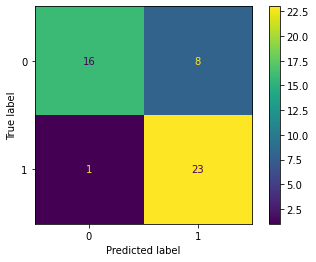

In [ ]:
plot_confusion_matrix(gradBoost, X_test, y_test) 